## **Importing libraries and datasets**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


In [2]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [3]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [4]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [5]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [6]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']= df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [7]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),               # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['avg_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [8]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,avg_size
0,CS1112,62.0,15,1012,1309,67.466667
1,CS1113,36.0,20,1490,1354,74.500000
2,CS1114,33.0,19,1432,1309,75.368421
3,CS1115,12.0,22,1659,1303,75.409091
4,CS1116,204.0,13,857,1155,65.923077


## **Calculating response rate**

In [9]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


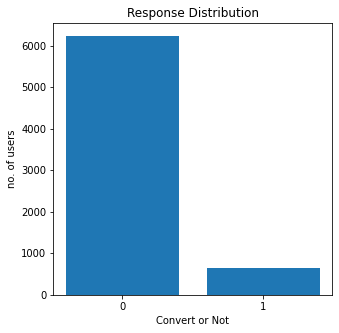

In [10]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [11]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,avg_size
0,CS1112,0,62.0,15,1012,1309,67.466667
1,CS1113,0,36.0,20,1490,1354,74.500000
2,CS1114,1,33.0,19,1432,1309,75.368421
3,CS1115,1,12.0,22,1659,1303,75.409091
4,CS1116,1,204.0,13,857,1155,65.923077


## **Creating train and test dataset**

In [12]:
## spliting dataframe into X and y

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [13]:
## creating train and test dataset
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.2, random_state=0)

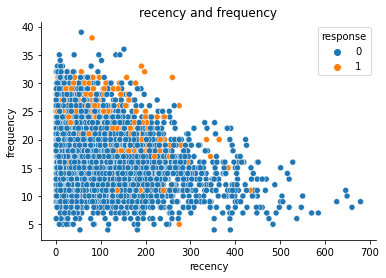

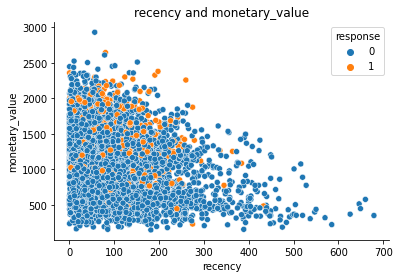

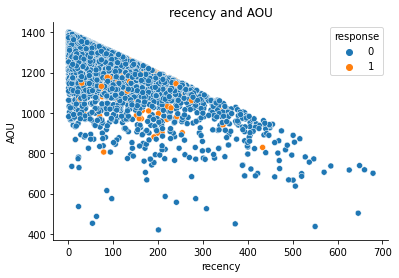

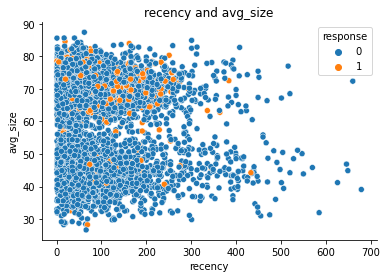

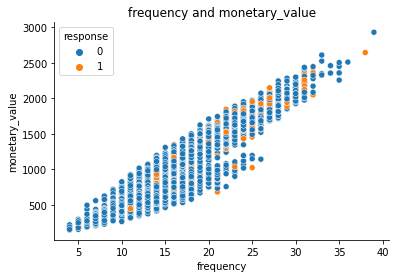

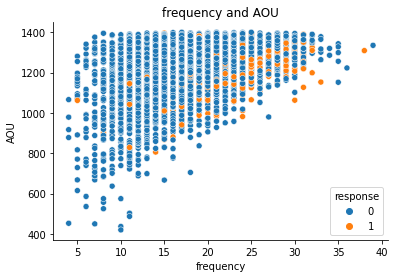

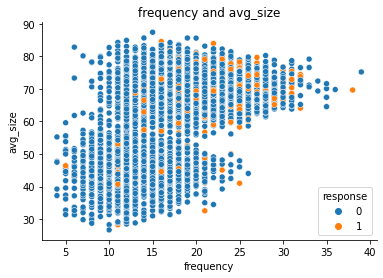

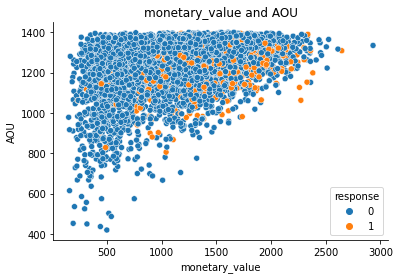

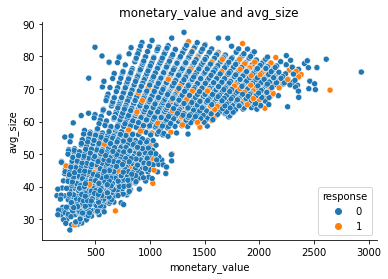

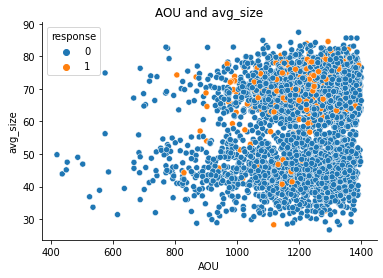

In [14]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU','avg_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU','avg_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

In [15]:
corrM = df_modeling_clv.corr()
corrM

,response,recency,frequency,monetary_value,AOU,avg_size
response,1.000000,0.023405,0.201333,0.205543,0.002463,0.142133
recency,0.023405,1.000000,-0.286019,-0.270120,-0.715406,-0.176771
frequency,0.201333,-0.286019,1.000000,0.934468,0.401191,0.535893
monetary_value,0.205543,-0.270120,0.934468,1.000000,0.376935,0.786731
AOU,0.002463,-0.715406,0.401191,0.376935,1.000000,0.245546
avg_size,0.142133,-0.176771,0.535893,0.786731,0.245546,1.000000


## **Fixing imbalanced with SMOTE**

In [16]:
sm = SMOTE(random_state=0)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

## **Logistic Regression**

In [17]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.69      0.65      0.67      4997
           1       0.67      0.70      0.69      4997

    accuracy                           0.68      9994
   macro avg       0.68      0.68      0.68      9994
weighted avg       0.68      0.68      0.68      9994

test set
              precision    recall  f1-score   support

           0       0.95      0.66      0.78      1240
           1       0.18      0.67      0.28       137

    accuracy                           0.66      1377
   macro avg       0.56      0.66      0.53      1377
weighted avg       0.87      0.66      0.73      1377



In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

'''Build pipline of classifiers'''
random_state = 11
# set all CPU
n_jobs = -1
# LogisticRegression
pipe_lr = Pipeline([('lr', LogisticRegression(random_state=random_state, n_jobs=n_jobs, max_iter=1000))])
# RandomForestClassifier
pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=random_state, oob_score=True, n_jobs=n_jobs))])
# KNeighborsClassifier
pipe_knn = Pipeline([('knn', KNeighborsClassifier(n_jobs=n_jobs))])
# DecisionTreeClassifier
pipe_dt = Pipeline([('dt', DecisionTreeClassifier(random_state=random_state, max_features='auto'))])
# BaggingClassifier
# note we use SGDClassifier as classier inside BaggingClassifier
pipe_bag = Pipeline([('bag',BaggingClassifier(base_estimator=SGDClassifier(random_state=random_state, n_jobs=n_jobs, max_iter=1500),\
                                              random_state=random_state,oob_score=True,n_jobs=n_jobs))])

In [19]:
'''Set parameters for Grid Search '''
# set number 
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=random_state)
# set for LogisticRegression
grid_params_lr = [{
                'lr__penalty': ['l2'],
                'lr__C': [0.3, 0.6, 0.7],
                'lr__solver': ['sag']
                }]
# set for RandomForestClassifier
grid_params_rf = [{
                'rf__criterion': ['entropy'],
                'rf__min_samples_leaf': [80, 100],
                'rf__max_depth': [25, 27],
                'rf__min_samples_split': [3, 5],
                'rf__n_estimators' : [60, 70]
                }]
# set for KNeighborsClassifier
grid_params_knn = [{'knn__n_neighbors': [16,17,18]}]

# set for DecisionTreeClassifier
grid_params_dt = [{
                'dt__max_depth': [8, 10],
                'dt__min_samples_leaf': [1, 3, 5, 7]
                  }]
# set for BaggingClassifier
grid_params_bag = [{'bag__n_estimators': [20, 25, 30]}]

In [20]:
'''Grid search objects'''
# for LogisticRegression
gs_lr = GridSearchCV(pipe_lr, param_grid=grid_params_lr,
                     scoring='accuracy', cv=cv) 
# for RandomForestClassifier
gs_rf = GridSearchCV(pipe_rf, param_grid=grid_params_rf,
                     scoring='accuracy', cv=cv)
# for KNeighborsClassifier
gs_knn = GridSearchCV(pipe_knn, param_grid=grid_params_knn,
                     scoring='accuracy', cv=cv)
# for DecisionTreeClassifier
gs_dt = GridSearchCV(pipe_dt, param_grid=grid_params_dt,
                     scoring='accuracy', cv=cv)
# for BaggingClassifier
gs_bag = GridSearchCV(pipe_bag, param_grid=grid_params_bag,
                     scoring='accuracy', cv=cv)

In [21]:
# models that we iterate over
look_for = [gs_lr, gs_rf, gs_knn, gs_dt, gs_bag]
# dict for later use 
model_dict = {0:'Logistic_reg', 1:'RandomForest', 2:'Knn', 3:'DesionTree', 4:'Bagging with SGDClassifier'}

In [22]:
''' Function to iterate over models and obtain results'''
# set empty dicts and list
result_acc = {}
result_auc = {}
models = []

for index, model in enumerate(look_for):
        print('+++++++ Start New Model ++++++++++++++++++++++')
        print('Estimator is {}'.format(model_dict[index]))
        model.fit(X_SMOTE_clv, y_SMOTE_clv)
        print('---------------------------------------------')
        print('best params {}'.format(model.best_params_))
        print('best score is {}'.format(model.best_score_))
        auc = roc_auc_score(y_test_clv, model.predict_proba(X_test_clv)[:,1])
        print('---------------------------------------------')
        print('Test Set')
        print('---------------------------------------------')
        print('ROC_AUC is {} and accuracy rate is {}'.format(auc, model.score(X_test_clv, y_test_clv)))
        print('---------------------------------------------')
        print('Train Set')
        auc_train = roc_auc_score(y_SMOTE_clv, model.predict_proba(X_SMOTE_clv)[:,1])
        print('ROC_AUC_train is {} and accuracy rate is {}'.format(auc_train, model.score(X_SMOTE_clv, y_SMOTE_clv)))
        print('---------------------------------------------')
        

        print('++++++++ End Model +++++++++++++++++++++++++++')
        models.append(model.best_estimator_)
        result_acc[index] = model.best_score_
        result_auc[index] = auc


+++++++ Start New Model ++++++++++++++++++++++
Estimator is Logistic_reg


C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


---------------------------------------------
best params {'lr__C': 0.3, 'lr__penalty': 'l2', 'lr__solver': 'sag'}
best score is 0.6708014667994657
---------------------------------------------
Test Set
---------------------------------------------
ROC_AUC is 0.7180303743819166 and accuracy rate is 0.6514161220043573
---------------------------------------------
Train Set
ROC_AUC_train is 0.7326940891370924 and accuracy rate is 0.6723033820292176
---------------------------------------------
++++++++ End Model +++++++++++++++++++++++++++
+++++++ Start New Model ++++++++++++++++++++++
Estimator is RandomForest


C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature n

C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature n

C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature n

---------------------------------------------
best params {'rf__criterion': 'entropy', 'rf__max_depth': 25, 'rf__min_samples_leaf': 80, 'rf__min_samples_split': 3, 'rf__n_estimators': 60}
best score is 0.720532788916981
---------------------------------------------
Test Set
---------------------------------------------
ROC_AUC is 0.706516364492583 and accuracy rate is 0.6514161220043573
---------------------------------------------
Train Set
ROC_AUC_train is 0.8332747096727118 and accuracy rate is 0.7470482289373624
---------------------------------------------
++++++++ End Model +++++++++++++++++++++++++++
+++++++ Start New Model ++++++++++++++++++++++
Estimator is Knn


C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, bu

---------------------------------------------
best params {'knn__n_neighbors': 16}
best score is 0.792475416887623
---------------------------------------------
Test Set
---------------------------------------------
ROC_AUC is 0.6550829997645397 and accuracy rate is 0.6833696441539578
---------------------------------------------
Train Set
ROC_AUC_train is 0.924487752487394 and accuracy rate is 0.8265959575745447
---------------------------------------------
++++++++ End Model +++++++++++++++++++++++++++
+++++++ Start New Model ++++++++++++++++++++++
Estimator is DesionTree
---------------------------------------------
best params {'dt__max_depth': 10, 'dt__min_samples_leaf': 3}
best score is 0.7474487994748126
---------------------------------------------
Test Set
---------------------------------------------
ROC_AUC is 0.6029932893807393 and accuracy rate is 0.654320987654321
---------------------------------------------
Train Set
ROC_AUC_train is 0.8741798010565395 and accuracy rate

C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_bagging.py:706: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
C:\Users\S540\AppD

---------------------------------------------
best params {'bag__n_estimators': 25}
best score is 0.6481902612968147
---------------------------------------------
Test Set
---------------------------------------------
ROC_AUC is 0.7312308688485989 and accuracy rate is 0.6855482933914306
---------------------------------------------
Train Set
ROC_AUC_train is 0.7215105929677479 and accuracy rate is 0.6534920952571542
---------------------------------------------
++++++++ End Model +++++++++++++++++++++++++++


In [23]:
predicted_y = []
expected_y = []
predictions = gs_bag.predict(X_test_clv.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

C:\Users\S540\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


test set
              precision    recall  f1-score   support

           0       0.94      0.69      0.80      1240
           1       0.19      0.64      0.29       137

    accuracy                           0.69      1377
   macro avg       0.56      0.66      0.54      1377
weighted avg       0.87      0.69      0.75      1377



The best model is SGDClassifier
The AUC train = 0.721
The AUC test = 0.731